# Tyssue Implementation of Lan et al. (2015)
### v0.01 - First Try
Siang Lim (siang@alumni.ubc.ca)

In [43]:
%matplotlib inline

import tyssue

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import tyssue as ty

from tyssue.core.generation import make_df, three_faces_sheet
from tyssue.core.sheet import Sheet
from tyssue.draw.plt_draw import sheet_view

---

### Model Settings Goes in Here

In [44]:
# Kinetic Parameters
qr = 0.02 #s-1
qb = 0.02 #s-1
k1 = 0.67 #s-1
k2 = 0.60 #s-1     #called km in old code 
k3 = 0.27 #s-1
k4 = 4.02 #nN-1
kr = 0.05 #s-1    #called ksh in old code
kb = 0.05 #s-1    #called kb1 in old code

# Biochemistry at Quasi-Steady State
Seq  = 0.5
Req  = qr/(kr*np.exp(-Seq))
Beq  = qb/(kb*Req)
Meq  = (k1*Req)/(k3 + k2*Beq)

# Mechanical Parameters
Am = 1.0 #0.50 0.10 # Myosin amplitude 
period = 147 #20 #147 #s
b = 0.324 #nN
eta = 4.63 #4.64 #nNs/um
miu = 0.031 #nN/um
K_cor = 0.1
tau_pre = 0.1
alpha = 0.05 #nN/um2 #alpha

In [45]:
def four_faces_sheet_array():
    
    restLength = 1.0
    cellsPerRow = np.array([1,2,1])
    
    # From Settings
    nRows = cellsPerRow.size
    totalCells = np.sum(cellsPerRow)
    
    # Number of faces
    Nc = totalCells 

    # Generate Centers
    y_dist = restLength*1.5
    x_dist = 2*np.sqrt(restLength**2-(restLength*0.5)**2)

    centers_x = np.zeros(shape=(totalCells,1))
    centers_y = np.zeros(shape=(totalCells,1))
    centers = np.zeros(shape=(totalCells,2))
    
    index = 0

    for i in range(np.size(cellsPerRow)):
        y = -(i-np.floor(len(cellsPerRow)/2))*y_dist
        init_x = -(cellsPerRow[i]-1)*x_dist/2

        for j in range(cellsPerRow[i]):
            x = init_x + j*x_dist
            centers_x[index] = x
            centers_y[index] = y
            index = index + 1

    centers = np.hstack([centers_x, centers_y])   
    
    # Generate Vertices
    angle=np.array([0,60,120,180,240,300])
    x_angles = np.cos(np.radians(angle+90))*restLength
    y_angles = np.sin(np.radians(angle+90))*restLength

    points_x = (np.tile(centers_x,(1,6)) + np.tile(x_angles,(4,1))).flatten().round(decimals=10)
    points_y = (np.tile(centers_y,(1,6)) + np.tile(y_angles,(4,1))).flatten().round(decimals=10)
    points = np.column_stack((points_x.flatten(),points_y.flatten()))
    points = points.round(decimals=5).tolist()

    # Initialize List
    clean_x = [points[0][0]]
    clean_y = [points[0][1]]

    # Do not add duplicated points/generate edge tuples
    cell_ind = 0
    edge_ind = 0
    
    for p in points:
        has_vertex = False
        for k in range(len(clean_x)):
            if (np.isclose(clean_x[k],p[0],rtol=1e-05) and np.isclose(clean_y[k],p[1],rtol=1e-05)):
                has_vertex = True
        if has_vertex == False:
            clean_x.append(p[0])
            clean_y.append(p[1])

    cleaned_points = np.column_stack([np.array(clean_x),np.array(clean_y)])

    edges = np.array([[0, 1],
                      [1, 2],
                      [2, 3],
                      [3, 4],
                      [4, 5],
                      [5, 0],
                      [2, 6],
                      [6, 7],
                      [7, 8],
                      [8, 9],
                      [9, 3],
                      [9, 10],
                      [10, 11],
                      [11, 12],
                      [12, 4],
                      [8,13],
                      [13,14],
                      [14,15],
                      [15,10]])

    Nv, Ne = len(cleaned_points), len(edges)
    print('Total Vertices: ', Nv)
    print('Total Edges: ', Ne)
    return cleaned_points, edges, (Nc, Nv, Ne)

In [46]:
def four_faces_sheet(zaxis=False):
    points, _, (Nc, Nv, Ne) = four_faces_sheet_array()

    coords = ['x', 'y']

    face_idx = pd.Index(range(Nc), name='face')
    vert_idx = pd.Index(range(Nv), name='vert')

    _edge_e_idx = np.array([[0, 1, 0], #cell 1
                            [1, 2, 0],
                            [2, 3, 0],
                            [3, 4, 0],
                            [4, 5, 0],
                            [5, 0, 0],
                            [2, 6, 1], #cell 2
                            [6, 7, 1],
                            [7, 8, 1],
                            [8, 9, 1],
                            [9, 3, 1],
                            [3, 2, 1],
                            [4, 3, 2], #cell 3
                            [3, 9, 2],
                            [9, 10, 2],
                            [10, 11, 2],
                            [11, 12, 2],
                            [12, 4, 2],
                            [9, 8, 3], #cell 4
                            [8, 13, 3],
                            [13, 14, 3],
                            [14, 15, 3],
                            [15, 10, 3],
                            [10, 9, 3]])

    edge_idx = pd.Index(range(_edge_e_idx.shape[0]), name='edge')

    specifications = {
        "face": {
            "x": 0.0,
            "y": 0.0,
            "num_sides": 6,
            "area": 1.0,
            "perimeter": 1.0
            },
         "vert": {
             "x": 0.0,
             "y": 0.0,
             "pressure": 0.0
             },
        "edge": {
            "srce": 0,
            "trgt": 0,
            "face": 0,
            "dx": 0.0,
            "dy": 0.0,
            "nz": 0.0,
            "length": 0.0,
            "Myo": 0.0,
            "Rok": 0.0,
            "Baz": 0.0,
            "Shroom": 0.0
            }
    }
    
    # ## Faces DataFrame
    face_df = make_df(index=face_idx,
                      spec=specifications['face'])

    # ## Junction vertices and edges DataFrames
    vert_df = make_df(index=vert_idx,
                      spec=specifications['vert'])
    edge_df = make_df(index=edge_idx,
                      spec=specifications['edge'])

    edge_df['srce'] = _edge_e_idx[:, 0]
    edge_df['trgt'] = _edge_e_idx[:, 1]
    edge_df['face'] = _edge_e_idx[:, 2]

    vert_df.loc[:, coords] = points

    datasets = {'face': face_df, 'vert': vert_df, 'edge': edge_df}
    return datasets, specifications

In [47]:
from tyssue.geometry.base_geometry import BaseGeometry
class MyGeometry(BaseGeometry):
    """Geomtetry methods for 2D planar cell arangements
    """
    @classmethod
    def update_all(cls, sheet):
        '''
        Updates the sheet geometry by updating:
        * the edge vector coordinates
        * the edge lengths
        * the face centroids
        * the normals to each edge associated face
        * the face areas
        '''
        cls.update_dcoords(sheet)
        cls.update_length(sheet)
        cls.update_centroid(sheet)
        cls.update_normals(sheet)
        cls.update_areas(sheet)
        cls.update_perimeters(sheet)

    @staticmethod
    def update_perimeters(sheet):
        '''
        Updates the perimeter of each face.
        '''
        sheet.face_df['perimeter'] = sheet.sum_face(sheet.edge_df['length'])

    @staticmethod
    def update_centroid(sheet):
        '''
        Updates the face_df `coords` columns as the face's vertices
        center of mass.
        '''
        upcast_pos = sheet.upcast_srce(sheet.vert_df[sheet.coords])
        upcast_pos.set_index(sheet.edge_df['face'],
                             append=True, inplace=True)
        sheet.face_df[sheet.coords] = upcast_pos.mean(level='face')
        
        
    @staticmethod
    def update_normals(sheet):

        coords = sheet.coords
        face_pos = sheet.upcast_face(sheet.face_df[coords]).values
        srce_pos = sheet.upcast_srce(sheet.vert_df[coords]).values
        trgt_pos = sheet.upcast_trgt(sheet.vert_df[coords]).values

        normals = np.cross(srce_pos - face_pos, trgt_pos - srce_pos)
        sheet.edge_df["nz"] = normals
        

    @staticmethod
    def update_areas(sheet):
        '''
        Updates the normal coordniate of each (srce, trgt, face) face.
        '''
        sheet.edge_df['sub_area'] = np.abs(sheet.edge_df['nz']) / 2
        sheet.face_df['area'] = sheet.sum_face(sheet.edge_df['sub_area'])

In [48]:
datasets, specs = four_faces_sheet()
sheet = Sheet('4_cells', datasets, specs, coords=['x', 'y'])
MyGeometry.update_all(sheet)
sheet.sanitize()

Total Vertices:  16
Total Edges:  19


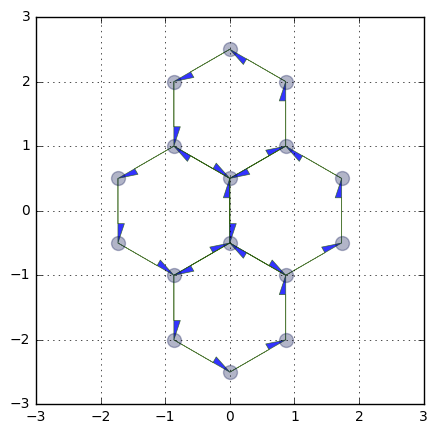

In [49]:
fig, ax = sheet_view(sheet)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
fig.set_size_inches((5, 5))

In [50]:
sheet.face_df

,perimeter,area,y,x,num_sides
face,,,,,
0,6.000016,2.598090,1.5,0.000000,6
1,5.999999,2.598075,0.0,-0.866027,6
2,5.999999,2.598075,0.0,0.866027,6
3,6.000016,2.598090,-1.5,0.000000,6


In [51]:
sheet.edge_df

,dx,face,dy,Shroom,Baz,Rok,srce,trgt,length,nz,Myo,sub_area
edge,,,,,,,,,,,,
0,-0.86603,0,-0.5,0.0,0.0,0.0,0,1,1.000004,0.866030,0.0,0.433015
1,0.00000,0,-1.0,0.0,0.0,0.0,1,2,1.000000,0.866030,0.0,0.433015
2,0.86603,0,-0.5,0.0,0.0,0.0,2,3,1.000004,0.866030,0.0,0.433015
3,0.86603,0,0.5,0.0,0.0,0.0,3,4,1.000004,0.866030,0.0,0.433015
4,0.00000,0,1.0,0.0,0.0,0.0,4,5,1.000000,0.866030,0.0,0.433015
5,-0.86603,0,0.5,0.0,0.0,0.0,5,0,1.000004,0.866030,0.0,0.433015
6,-0.86602,1,-0.5,0.0,0.0,0.0,2,6,0.999995,0.866022,0.0,0.433011
7,0.00000,1,-1.0,0.0,0.0,0.0,6,7,1.000000,0.866023,0.0,0.433012
8,0.86602,1,-0.5,0.0,0.0,0.0,7,8,0.999995,0.866022,0.0,0.433011


In [52]:
sheet.vert_df

,pressure,y,x
vert,,,
0,0.0,2.5,0.00000
1,0.0,2.0,-0.86603
2,0.0,1.0,-0.86603
3,0.0,0.5,-0.00000
4,0.0,1.0,0.86603
5,0.0,2.0,0.86603
6,0.0,0.5,-1.73205
7,0.0,-0.5,-1.73205
8,0.0,-1.0,-0.86603


In [53]:
sheet.datasets['edge']['Myo'] = Meq
sheet.datasets['edge']['Rok'] = Req
sheet.datasets['edge']['Baz'] = Beq
sheet.datasets['edge']['Shroom'] = Seq

In [54]:
sheet.datasets['edge'].head()

,dx,face,dy,Shroom,Baz,Rok,srce,trgt,length,nz,Myo,sub_area
edge,,,,,,,,,,,,
0,-0.86603,0,-0.5,0.5,0.606531,0.659489,0,1,1.000004,0.86603,0.697026,0.433015
1,0.00000,0,-1.0,0.5,0.606531,0.659489,1,2,1.000000,0.86603,0.697026,0.433015
2,0.86603,0,-0.5,0.5,0.606531,0.659489,2,3,1.000004,0.86603,0.697026,0.433015
3,0.86603,0,0.5,0.5,0.606531,0.659489,3,4,1.000004,0.86603,0.697026,0.433015
4,0.00000,0,1.0,0.5,0.606531,0.659489,4,5,1.000000,0.86603,0.697026,0.433015


### Next: Define ODEs

#### Mechanical forces on vertices (total: 16 vertices):

$$ \frac{dx_{i}}{dt} = \frac{1}{\eta}\Bigg[\sum\limits_{j} f_{ij}\frac{{x_j}-{x_i}}{\left|x_j-x_i\right|} + f_{mi}e_{ci}+pe_{ni}\Bigg] $$

where $e_{ci}$ is a unit vector pointing from vertex $i$ toward the centroid of the cell and $e_{ni}$ is an outward normal vector that bisects the angle formed by the two edges meeting at vertex $i$.

$$ f_{ij} = \mu\big(l_{ij}-l_0\big)-\beta\big(m_{ij}-m^e\big) $$

$$ f_{mi} = \beta\Big[A_m\sin^2{\Big(\frac{t\pi}{T}+\phi\Big)}\Big] $$

#### Biochemistry on each edges (total: 19 edges):

$$ \frac{dm}{dt} = k_1R-k_2mB-(k_3 \exp^{-k_4f_{ij}})m $$

$$ \frac{dR}{dt}=q_r-k_re^{-S}R $$

$$ \frac{dB}{dt} = q_b - k_b RB $$

#### Order of equations:

- Movement x, 16 vertices
- Movement y, 16 vertices
- Rok, 19 edges
- Baz, 19 edges
- Myo, 19 edges

In [56]:
# Build matrix of unknowns:

vert_x = sheet.datasets['vert']['x']
vert_y = sheet.datasets['vert']['y']
edge_Baz = sheet.datasets['edge']['Baz']
edge_Rok = sheet.datasets['edge']['Rok']
edge_Myo = sheet.datasets['edge']['Myo']

Y = pd.concat([vert_x, vert_y, edge_Baz, edge_Rok, edge_Myo], axis=0)


In [59]:
print('Total ODEs: ')
len(Y)

Total ODEs: 


104

In [61]:
def diff_equations(vert_x,vert_y,edge_Baz,edge_Rok,edge_Myo):
    # vert_x_new = (1/eta)*[sum(f_ij*dir_Vec) + f_m*centroid_Vec + p*bisection_Vec]
    pass

,dx,face,dy,ny,dz,srce,trgt,length,nx,nz,sub_area,sub_vol
edge,,,,,,,,,,,,
0,1.0,0,0.000,0.0,0.0,0,1,1.000000,-0.0,0.866,0.433,-1.732
1,0.5,0,0.866,0.0,0.0,1,2,0.999978,-0.0,0.866,0.433,-1.732
2,-0.5,0,0.866,-0.0,0.0,2,3,0.999978,0.0,0.866,0.433,-1.732
3,-1.0,0,0.000,-0.0,0.0,3,4,1.000000,0.0,0.866,0.433,-1.732
4,-0.5,0,-0.866,0.0,0.0,4,5,0.999978,0.0,0.866,0.433,-1.732
5,0.5,0,-0.866,0.0,0.0,5,0,0.999978,0.0,0.866,0.433,-1.732
6,-0.5,1,0.866,-0.0,0.0,0,5,0.999978,0.0,0.866,0.433,-1.732
7,-1.0,1,0.000,-0.0,0.0,5,6,1.000000,0.0,0.866,0.433,-1.732
8,-0.5,1,-0.866,0.0,0.0,6,7,0.999978,0.0,0.866,0.433,-1.732


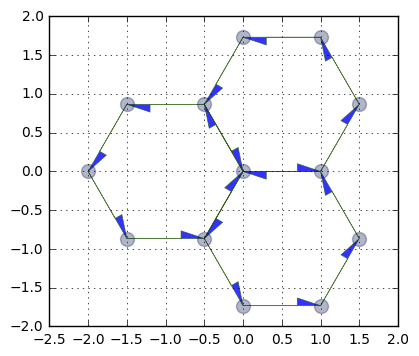

In [41]:
## 3-sheet example for comparison

from tyssue.geometry.sheet_geometry import SheetGeometry  as geom

datasets, specs = three_faces_sheet()
sheet3 = Sheet('3cells_2D', datasets, specs)

geom.update_all(sheet3)
fig, ax = sheet_view(sheet3, ['x', 'y'])

sheet3.datasets['edge']
